## Welcome to the demo walktrough of the [CLIC-semseg](https://github.com/paulispaulis/CLIC-semseg) repository
Follow the steps and see results!

### Clone the repository

In [1]:
!git clone https://github.com/paulispaulis/CLIC-semseg.git

%cd CLIC-semseg

fatal: destination path 'CLIC-semseg' already exists and is not an empty directory.
/content/CLIC-semseg


### Install dependencies

In [2]:
!pip install -r requirements.txt

### Import dependecies

In [3]:
import os
import sys
import torch
sys.path.append('..')
#from src import defdevice


global def_device

# If you have a cuda device, specify in the force_device function
if torch.cuda.is_available():
    def_device = 'cuda:0'
    torch.cuda.set_device(def_device)
else:
    def_device = "cpu"

#from src import nns
#from src import embedders
#from src import segmodel
#from demo.demo_functions import run_image, run_video

In [4]:
"""
File intended for operations relating to messing around with images.
"""

from PIL import Image
import numpy as np

def open_image(path):
    """
    Opens an image and returns it as a numpy array.
    """
    image = Image.open(path)
    res = np.array(image)
    return res

import torch.nn.functional as f
def rescale(data, image):
    """
    Interpolates data to size of image.
    data should be tensor of size [n, y1, x1] or [y1, x1].
    image should be numpy array of size [y2, x2, 3].

    returns data interpolated to size [n, y2, x2] or [y2, x2].
    """

    if len(data.shape) == 2:
        data = data.reshape([1, 1] + list(data.shape))
        res = f.interpolate(data, size = image.shape[:2], mode = 'bilinear')
        return res[0, 0]

    elif len(data.shape) == 3:
        data = data.reshape([1] + list(data.shape))
        res = f.interpolate(data, size = list(image.shape[:2]), mode = 'bilinear')
        return res[0]

def toRGB(image):
    """
    Forces image to be of shape [y, x, 3].
    """
    #Handle grayscale images.
    if len(image.shape) == 2:
        image = np.stack([image for i in range(3)], axis = 2)

    #Handle RGBA images.
    if image.shape[2] > 3:
        image = image[:, :, :3]

    return image

In [5]:
"""This file contains functions for image and video processing using semantic segmentation models (demo)."""

import sys
sys.path.append('..')
#from src import imageops
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import streamlit as st
import cv2


colorsl = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0], [255, 255, 255], [128, 128, 128], [128, 0, 0], [0, 128, 0], [0, 0, 128]]
colors = np.array(colorsl)
colorsl = [[c / 255 for c in color] for color in colorsl]

def array_to_rgb(array):
    """
    Converts a multi-channel array to an RGB image.

    Args:
        array (numpy.ndarray): Input multi-channel array.

    Returns:
        numpy.ndarray: RGB image array.
    """

    n, y, x = array.shape
    max_indices = np.argmax(array, axis=0)
    rgb_image = np.zeros((y, x, 3), dtype=np.uint8)
    for i in range(n):
        mask = max_indices == i
        rgb_image[mask] = colors[i]

    return rgb_image


def run_image(smodel, path, labels, multilabel = False, aggregation = 'max', rough_labels = None, web = False):
    """
    Runs semantic segmentation on a images and displays the result.

    Args:
        smodel (object): Semantic segmentation model.
        path (str): Path to the input image.
        labels (list): List of labels to be segmented.
        multilabel (bool, optional): Whether multilabel segmentation is used. Defaults to False.
        aggregation (str, optional): Aggregation method for multilabel segmentation. Defaults to 'max'.
        rough_labels (list, optional): Rough labels for multilabel segmentation. Defaults to None.
        web (bool, optional): Whether to display the result in a web interface. Defaults to False.
    """

    img = open_image(path)
    if multilabel == False:
        hmaps = smodel.forward(img, labels)
    else:
        hmaps = smodel.forward_multilabel(img, labels, aggregation = aggregation)

    fig = plt.figure(figsize=(28, 8))

    width = ((len(labels) + 2 + 1) // 2) * 2
    gs = gridspec.GridSpec(2, width, width_ratios=[1, 0.05]*(width // 2))

    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img, aspect = 'auto')
    ax0.set_xticks([])
    ax0.set_yticks([])

    ax1 = fig.add_subplot(gs[0, 2])
    ax1.imshow(array_to_rgb(hmaps), aspect = 'auto')
    ax1.set_xticks([])
    ax1.set_yticks([])

    if multilabel:
        if rough_labels is None:
            labels_s = [l[0] for l in labels]
        else:
            labels_s = rough_labels
    else:
        labels_s = labels

    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colorsl[:len(labels_s)], labels_s)]
    ax1.legend(handles=legend_patches)

    # Individual heatmaps and their colorbars
    for idx, l in enumerate(labels):
        ax = fig.add_subplot(gs[(idx * 2 + 4) // width, (idx*2 + 4) % width])
        cax = fig.add_subplot(gs[(idx * 2 + 5) // width, (idx*2 + 5) % width])
        pos = cax.get_position()
        new_pos = [pos.x0 - 0.01, pos.y0, pos.width, pos.height]
        cax.set_position(new_pos)
        ax.set_xticks([])
        ax.set_yticks([])

        im = ax.imshow(hmaps[idx], aspect = 'auto', vmin = 0, vmax = 1)
        plt.colorbar(im, cax=cax, pad = 0)
        ax.set_title(labels_s[idx])

    if web:
        st.pyplot(fig)
    else:
        plt.savefig(path[:-4] + 'output' + '.png', bbox_inches = 'tight')


def run_video(path, smodel, labels, width, height, output_path, fps = 30, frame_count = 1000, frame_average = 5, draw_period = 10, web = False):
    """
    Runs semantic segmentation on a video and outputs the processed video.

    Args:
        path (str): Path to the input video.
        smodel (object): Semantic segmentation model.
        labels (list): List of labels to be segmented.
        width (int): Width of the output video.
        height (int): Height of the output video.
        output_path (str): Path to save the processed video.
        fps (int, optional): Frames per second of the output video. Defaults to 30.
        frame_count (int, optional): Maximum number of frames to process. Defaults to 1000.
        frame_average (int, optional): Number of frames to average over for smoother segmentation. Defaults to 5.
        draw_period (int, optional): Interval for displaying intermediate results. Defaults to 10.
        web (bool, optional): Whether to display intermediate results in a web interface. Defaults to False.
    """

    # Define the codec using VideoWriter_fourcc and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    video_reader = VideoReader(path)

    hmaps = []
    for i in range(frame_count):
        frame = video_reader.get_frame() # Get next video frame
        if frame is -1:
            break
        frame = frame[:height, :width]

        #There's prolly a problem with RGB BGR.
        hmaps.append(run_image_vid(smodel, frame, labels))

        #Averaging over previous heatmaps
        if len(hmaps) > frame_average:
            hmaps = hmaps[1:]
        avg = np.array(hmaps).mean(axis = 0)
        res_frame = array_to_rgb(avg)

        out.write(res_frame // 2 + frame // 2) #Writing to video file

        #spam
        if i % draw_period is 0 and not web:
            legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colorsl[:len(labels)], labels)]
            print('On frame ', i, '/', frame_count)
            plt.figure()
            plt.imshow(res_frame)
            plt.legend(handles = legend_patches)
            plt.title('frame ' + str(i))

    video_reader.release()

    out.release()


def run_image_vid(smodel, img, labels):
    """
    Inference on a single image.

    Args:
        smodel (object): Semantic segmentation model.
        img (numpy.ndarray): Input image.
        labels (list): List of labels to be segmented.

    Returns:
        numpy.ndarray: Segmented image.
    """

    hmaps = smodel.forward(img, labels)
    return hmaps


class VideoReader:
    """Video reader class for reading frames from a video file."""

    def __init__(self, video_path):
        """
        Initializes the VideoReader.

        Args:
            video_path (str): Path to the video file.
        """

        self.cap = cv2.VideoCapture(video_path)

    def get_frame(self):
        """
        Reads the next frame from the video.

        Returns:
            numpy.ndarray: The next frame, or -1 if end of video is reached.
        """

        ret, frame = self.cap.read()
        if not ret:
            return -1
        return frame

    def release(self):
        """Releases the video capture."""

        self.cap.release()

<>:133: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:133: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-ecb243fc9357>:133: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if frame is -1:
<ipython-input-5-ecb243fc9357>:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i % draw_period is 0 and not web:


In [6]:
"""
File is for functions related to converting between torch and numpy tensors.
"""

def tnp(tens):
    """
    Converts tensor to a numpy array.
    Takes into account all the mess of cudas and detachments.
    """

    res = tens

    res = res.detach()

    res = res.to('cpu')

    res = res.numpy()

    return res

In [7]:
"""
File for defining segmentation models.
"""

#import src.defdevice as defdevice
import numpy as np
#import src.tensorconversions as tensorconversions

class SegModel():
    """
    Abstract class for a model that takes an image and labels, and returns a segmentation.
    """
    def __init__(s):
        pass

    def forward(s, image, labels):
        """
        image - numpy array of shape [y, x, 3].
        labels - list of strings.

        Should return numpy array of shape [len(labels), y, x].
        """
        raise NotImplemented()

    def forward_multilabel(s, image, labels, aggregation = 'max'):
        """
        Segments image according to multiple labels per segmentation class.
        e.g. for RUGD6.

        image - numpy array of shape [y, x, 3].
        labels - list of list of strings.
        aggregation - how to smoosh together multiple label's results.
            options are - "sum", "max".

        Returns [len(labels), y, x].
        """
        labels_merged = sum(labels, [])
        amounts = [len(l) for l in labels]

        all_res = s.forward(image, labels_merged)

        res = np.zeros([len(labels), all_res.shape[1], all_res.shape[2]], dtype = np.float32)
        all_idx = 0
        for merged_idx, amount in enumerate(amounts):
            for idx in range(amount):
                if aggregation == 'max':
                    res[merged_idx] = np.maximum(res[merged_idx], all_res[all_idx])
                elif aggregation == 'sum':
                    res[merged_idx] = res[merged_idx] + all_res[all_idx]
                else:
                    raise ValueError('Aggregation ' + str(aggregation) + ' not recognized')
                all_idx+= 1

        return res


import torch
import torch.nn.functional as f
import json
class CSModel(SegModel):
    """
    CLIPSchitzo model.
    """

    def __init__(s, image_embedder, text_embedder, transform_net):
        s.image_embedder = image_embedder
        s.text_embedder = text_embedder
        s.transform_net = transform_net

        s.cache_labels = ''
        s.cache = None

    def forward_labels(s, labels):
        if s.cache_labels != labels:
            s.cache = s.text_embedder.forward(labels)
            s.cache = torch.tensor(text_embeddings, device = def_device, requires_grad = False)
            s.cache = s.transform_net.forward(s.cache)

        return s.cache

    def forward(s, image, labels):
        """
        image - numpy array of shape [y, x, 3]
        """
        print("FORWARD START ==========================")
        print("Labels: ", labels)
        with open('LabelsGBA.json', 'w') as file:
            json.dump(labels, file)
        print("LabelsSaved")
        with open('LabelsGBA.json', 'r') as file:
            labels = json.load(file)
        print("LabelsLoaded")

        image_embeddings = s.image_embedder.forward(image)
        text_embeddings = s.text_embedder.forward(labels)

        image_embeddings = torch.tensor(image_embeddings, device = def_device, requires_grad = False)
        text_embeddings = torch.tensor(text_embeddings, device = def_device, requires_grad = False)

        #print("TextEmbeddings: ", text_embeddings)

        with torch.no_grad():
            trans_embeddings = s.transform_net.forward(text_embeddings)

            torch.set_printoptions(threshold=float('inf'))
            #print("TransTextEmbeddings (length = ", len(trans_embeddings), " ): ", trans_embeddings)
            print("TransTextEmbeddings (shape = ", trans_embeddings.shape, "; dtype = ", trans_embeddings.dtype ," ): ", trans_embeddings)
            nptrans = tnp(trans_embeddings)
            print("TransTextEmbeddingsNP (shape = ", nptrans.shape, "; dtype = ", nptrans.dtype ," ): ", nptrans)
            plist = nptrans.tolist()
            print("TransTextEmbeddingsList: ", plist)

            ttt = torch.tensor(plist)
            print("TransTextEmbeddings (shape = ", ttt.shape, "; dtype = ", ttt.dtype ," ): ", ttt)


            np.save('TransTextEmbeddingsGBA.pt', nptrans)
            print("EmbeddingsSaved")
            np.load('TransTextEmbeddingsGBA.pt', nptrans)
            print("EmbeddingsLoaded")

            #prods = torch.einsum('eyx,ne->nyx', image_embeddings, trans_embeddings)
            prods = torch.einsum('eyx,ne->nyx', image_embeddings, ttt)
            probs = torch.softmax(prods, dim = 0)
            probs = probs.unsqueeze(0)
            probs = f.interpolate(probs, size = image.shape[:2], mode = 'bilinear')
            probs = probs[0]
            probs = tnp(probs)

        print("FORWARD END ++++++++++++++++++++++++++")

        return probs

In [8]:
"""
File for defining neural networks.
"""

import torch
import torch.nn.functional as f
import numpy as np
import math

#from src import nns
#from src import defdevice

class NN():
    def __init__(s):
        s.parameters = []

    def bias(s, size):
        tens = torch.zeros(size, dtype = torch.float32, requires_grad = True, device = def_device)
        s.parameters.append(tens)
        return tens

    def weight(s, ins, outs):
        k = 1/math.sqrt(ins)
        data = np.random.uniform(-k, k, size = [ins, outs])
        tens = torch.tensor(data, dtype = torch.float32, requires_grad = True, device = def_device)
        s.parameters.append(tens)
        return tens

    def forward(s):
        raise NotImplemented()

    def save(s, path):
        """
        Path shouldn't contain extension.
        """
        raise NotImplemented()

    def load(s, path):
        """
        Path shouldn't contain extension.
        """
        raise NotImplemented()

class Linear(NN):
    """
    Just one linear layer.
    """
    def __init__(s, ins, outs):
        super().__init__()
        s.w = s.weight(ins, outs)
        s.b = s.bias(outs)

    def forward(s, x):
        res = torch.matmul(x, s.w) + s.b
        return res

    def save(s, path):
        torch.save(s.parameters, path + '.pt')

    def load(s, path):
        s.parameters = torch.load(path + '.pt', map_location = def_device)
        s.w = s.parameters[0].to(def_device)
        s.b = s.parameters[1].to(def_device)

In [9]:
#import src.defdevice as defdevice

import numpy as np
import torch
#from src.tensorconversions import tnp
#import src.defdevice as defdevice

if def_device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

class ImageEmbedder():
    """
    Abstract class for turning images into embedding tensors.
    In order to define an ImageEmbedder, break it into this shape.
    """

    def __init__(s):
        s.embedding_shape = None
        s.spacial_shape = [None, None]
        #Please define these values.

    def _forward(s, image):
        """
        This function should take a numpy array of the shape [x, y, 3],
        and return a embedding as a numpy array of shape [s.embedding_size, x, y].
        """
        raise NotImplemented('You forgot to implement the image embedder\'s _forward function.')

    def forward(s, images):
        """
        Function takes a list of numpy array of the shape [x, y, 3].
        and returns a numpy array of embedding of the shape [len(images), s.embedding_size, x,  y].

        Alternatively if the input is not a list, but just an image, returns [s.embedding_size, x, y].
        """
        if type(images) == list:
            res = []
            for image in images:
                res.append(s._forward(image))
            res = np.stack(res, axis = 0)
        else:
            res = s._forward(images)

        return res

    def __str__(s):
        res = 'ImageEmbedder of class ' + str(s.__class__.__name__) + '\n'
        res+= 'Embedding shape: ' + str(s.embedding_shape) + '\n'
        res+= 'Output spacial shape: ' + str(s.spacial_shape)

        return res


class TextEmbedder():
    """
    Abstract class for turning text into embedding tensors.
    In order to define a TextEmbedder, break it into this shape.
    """

    def __init__(s):
        s.embedding_shape = None
        #Please define this value

    def _forward(s, text):
        """
        This function should take a python string, and
        return an embedding as a numpy array of shape [s.embedding_size].
        """
        raise NotImplemented('You forgot to implement the text embedder\'s _forward function.')

    def forward(s, texts):
        """
        Function takes a list of python strings,
        and returns a numpy array of shape [len(text), s.embedding_size].

        Alternatively if text is not a list, but just a string, returns a numpy array of size [s.embedding_size].
        """

        if type(texts) == list:
            res = []
            for text in texts:
                res.append(s._forward(text))
            res = np.stack(res, axis = 0)
        elif type(texts) == str:
            res = s._forward(texts)
        else:
            raise TypeError('texts parameter wasn\'t string or list of string.')

        return res

    def __str__(s):
        res = 'TextEmbedder of class ' + str(s.__class__.__name__) + '\n'
        res+= 'Embedding shape: ' + str(s.embedding_shape)

        return res

import traceback

def test(embedder):
    """
    Just pass an instance of an ImageEmbedder or TextEmbedder class to this function, to perform tests.

    If the function crashes, something is wrong.
    """
    def report(exc):
        print(exc)
        print(traceback.print_exc())

    if isinstance(embedder, ImageEmbedder):
        print(embedder)

        if embedder.embedding_shape is None:
            raise Exception('Embedder doesn\'t have embedding_shape defined.')

        if embedder.spacial_shape == [None, None]:
            raise Exception('Embedder doesn\'t have spacial_shape defined.')

        try:
            res = embedder.forward([np.zeros([10, 10, 3])])[0]
        except Exception as e:
            report(e)
            raise Exception('embedder._forward() function crashes.')

        if res is None:
            raise Exception('embedder._forward() function doesn\'t return result.')

        if type(res) is not np.ndarray:
            raise Exception('Value returned by embedder._forward() isn\'t a numpy array')
        expected_shape = [embedder.embedding_shape] + embedder.spacial_shape

        if list(res.shape) != expected_shape:
            raise Exception('Shape of output embedder._forward() isn\'t what was expected; expected ' + str(expected_shape) + '; got ' + str(res.shape))

    elif isinstance(embedder, TextEmbedder):
        print(embedder)

        if embedder.embedding_shape is None:
            raise Exception('Embedder doesn\'t have embedding_shape defined.')

        try:
            res = embedder.forward(['Test String'])[0]
        except Exception as e:
            report(e)
            raise Exception('embedder._forward() function crashes.')

        if res is None:
            raise Exception('embedder._forward() function doesn\'t return result.')

        if type(res) is not np.ndarray:
            raise Exception('Value returned by embedder._forward() isn\'t a numpy array')
        expected_shape = [embedder.embedding_shape]

        if list(res.shape) != expected_shape:
            raise Exception('Shape of output embedder._forward() isn\'t what was expected; expected ' + str(expected_shape) + '; got ' + str(res.shape))

    else:
        raise ValueError('Object passed to test function doesn\'t inherit from ImageEmbedder or TextEmbedder.')

    print('Looks clean to me. But I\'m just a robot so what do I know.')



#Part where the specific embedder implementations should start.

class TestImageEmbedder(ImageEmbedder):
    def __init__(s):
        super().__init__()
        s.embedding_shape = 50
        s.spacial_shape = [32, 64]

    def _forward(s, image):
        return np.zeros([50, 32, 64])


class TestTextEmbedder(TextEmbedder):
    def __init__(s):
        super().__init__()
        s.embedding_shape = 50

    def _forward(s, text):
        return np.zeros([50])


from transformers import SamModel, SamProcessor
class SAMImageEmbedder(ImageEmbedder):

    def __init__(s):
        super().__init__()
        s.embedding_shape = 256
        s.spacial_shape = [64, 64]
        s.model_name = "facebook/sam-vit-huge"
        s.model = SamModel.from_pretrained(s.model_name).to(defdevice.def_device)
        s.image_processor = SamProcessor.from_pretrained(s.model_name)

        #This part is necessary because there's a bug in SAM's code.
        def _modified_call(
            self,
            images=None,
            input_points=None,
            input_labels=None,
            input_boxes=None,
            return_tensors = None,
            **kwargs,
        ):
            """
            This method uses [`SamImageProcessor.__call__`] method to prepare image(s) for the model. It also prepares 2D
            points and bounding boxes for the model if they are provided.
            """
            encoding_image_processor = self.image_processor(
                images,
                return_tensors=return_tensors,
                **kwargs,
            )

            # pop arguments that are not used in the foward but used nevertheless
            original_sizes = encoding_image_processor["original_sizes"]

            if hasattr(original_sizes, "numpy"):  # Checks if Torch or TF tensor
                original_sizes = original_sizes.cpu().numpy()

            input_points, input_labels, input_boxes = self._check_and_preprocess_points(
                input_points=input_points,
                input_labels=input_labels,
                input_boxes=input_boxes,
            )

            encoding_image_processor = self._normalize_and_convert(
                encoding_image_processor,
                original_sizes,
                input_points=input_points,
                input_labels=input_labels,
                input_boxes=input_boxes,
                return_tensors=return_tensors,
            )

            return encoding_image_processor

        s._modified_call = _modified_call

    def _forward(s, image):
        with torch.no_grad():
            inputs = s._modified_call(s.image_processor, image, return_tensors="pt").to(defdevice.def_device)
            image_embeddings = s.model.get_image_embeddings(inputs["pixel_values"])

            #normalize
            norm = torch.norm(image_embeddings[0], dim=0, p=2, keepdim=True)
            res = tnp(image_embeddings[0] / norm)

        return res

    def __str__(s):
        res = super().__str__()
        res += '\nModel name - ' + s.model_name

        return res

from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
class M2FImageEmbedder(ImageEmbedder):
    def __init__(s):
        super().__init__()
        s.embedding_shape = 256
        s.spacial_shape = [96, 96]
        s.model_name = "facebook/mask2former-swin-large-coco-panoptic"
        s.image_processor = AutoImageProcessor.from_pretrained(s.model_name)
        s.model = Mask2FormerForUniversalSegmentation.from_pretrained(s.model_name).to(def_device)

    def _forward(s, image):
        inputs = s.image_processor(image, return_tensors="pt").to(def_device)
        outputs = s.model(**inputs)

        #normalize
        norm = torch.norm(outputs[3][0], dim=0, p=2, keepdim=True)
        res = tnp(outputs[3][0] / norm)

        return res

    def __str__(s):
        res = super().__str__()
        res += '\nModel name - ' + s.model_name

        return res

from transformers import CLIPProcessor, CLIPModel
class CLIPTextEmbedder(TextEmbedder):
    def __init__(s):
        super().__init__()
        s.embedding_shape = 512
        s.model_name = "openai/clip-vit-base-patch32"
        s.clip_model = CLIPModel.from_pretrained(s.model_name).to(def_device)
        s.clip_processor = CLIPProcessor.from_pretrained(s.model_name)

    def _forward(s, text):
        inputs = s.clip_processor(text = [text], images = [np.zeros([10, 10, 3], dtype = np.float32)], return_tensors="pt", padding=True)
        outputs = s.clip_model(**inputs)
        return tnp(outputs.text_embeds[0])

    def __str__(s):
        res = super().__str__()
        res += '\nModel name - ' + s.model_name

        return res

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


### Initialize the model and the embedders

In [10]:
image_embr = M2FImageEmbedder()
text_embr = CLIPTextEmbedder()
model = Linear(1, 1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


FORWARD START ==========================
Labels:  ['void', 'sky', 'sign', 'concrete', 'asphalt', 'gravel', 'grass', 'dirt', 'sand', 'mulch', 'rock', 'rock-bed', 'water', 'tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'picnic-table', 'bridge']
LabelsSaved
LabelsLoaded


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


TransTextEmbeddings (shape =  torch.Size([25, 256]) ; dtype =  torch.float32  ):  tensor([[ 8.3874e-01, -8.5883e-02, -1.3854e+00, -1.9194e+00, -1.2395e+00,
         -2.1202e+00,  3.6916e+00,  1.8741e+00, -1.7077e+00,  2.2016e+00,
         -2.6281e+00,  9.1632e-01, -1.7708e+00,  9.2092e-01, -2.8470e+00,
         -3.8051e+00, -2.5312e+00, -2.6488e+00,  6.4374e-01,  1.0242e-01,
         -1.9802e+00,  1.8229e+00, -1.7128e+00,  4.0546e-01,  3.3098e-01,
         -2.9310e+00, -1.7648e+00,  2.3281e+00, -4.9176e+00,  5.8577e-01,
          2.9249e+00, -1.0693e+00, -1.7662e+00, -3.6997e+00, -1.4871e+00,
          9.2460e-01,  1.9688e+00, -8.1285e+00,  1.7455e+00,  2.3491e+00,
          2.7301e+00, -2.2404e+00, -5.9727e-01, -1.0337e-01,  1.9181e+00,
          2.1036e+00, -5.2017e+00,  3.2492e-01,  2.9123e-01,  3.2892e+00,
         -3.7191e+00, -1.9507e+00,  2.3649e+00,  3.2820e+00,  1.7875e+00,
         -9.8587e-01, -1.8596e+00,  8.9934e-01, -8.8838e-01, -3.2435e-01,
         -2.8832e+00,  2.2025e

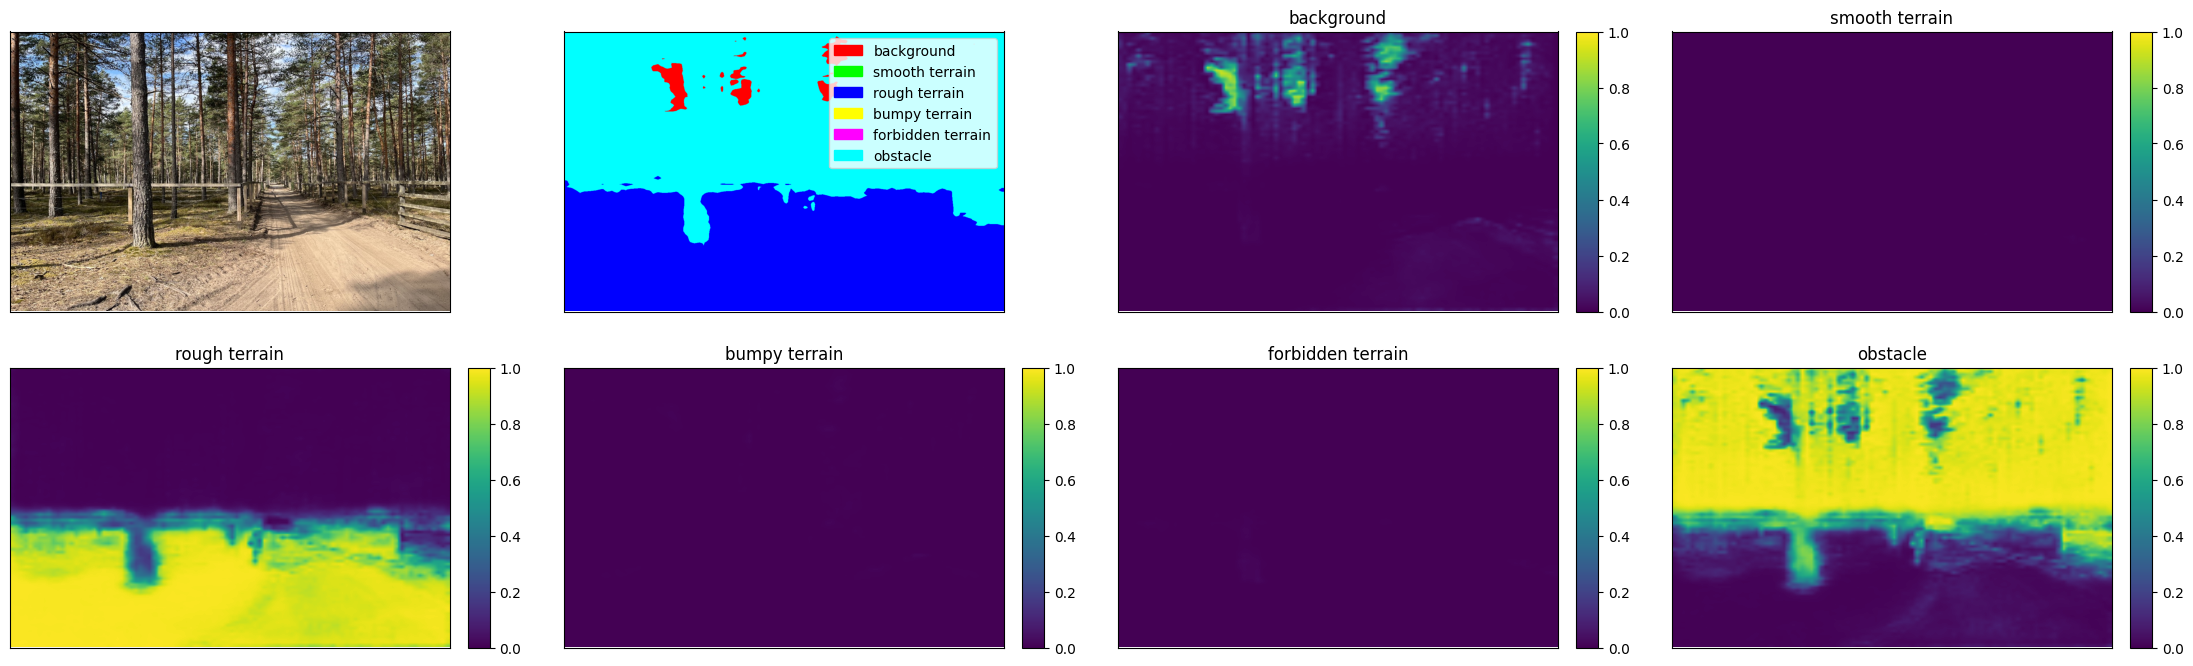

In [11]:
model.load("CSRUGDFineTuned")
smodel = CSModel(image_embr, text_embr, model)

#file_list = ['./FP/fp01.jpeg', './FP/fp05.jpeg', './FP/fp06.jpeg', './FP/fp13.jpeg'] #Images to run model on.
file_list = ['./FP/fp01.jpeg'] #Images to run model on.

labels = ['void,sky,sign',
          'concrete,asphalt',
          'gravel,grass,dirt,sand,mulch',
          'rock,rock-bed',
          'water',
          'tree,pole,vehicle,container/generic-object,building,log,bicycle,person,fence,bush,picnic-table,bridge']
labels = [st.split(',') for st in labels]

rough_labels = ['background', 'smooth terrain', 'rough terrain', 'bumpy terrain', 'forbidden terrain', 'obstacle']

for path in file_list:
    run_image(smodel, path, labels, multilabel = True, aggregation = 'sum', rough_labels = rough_labels)

In [12]:
b = 7 / 0

ZeroDivisionError: division by zero

### Load the model and test it out

Specify the labels and your image under file_list

In [ ]:
model.load("./CSTableModel") # Specify the weights you want to load
smodel = CSModel(image_embr, text_embr, model)

file_list = ['./FP/fp01.jpeg'] # Images to run the model on.
labels = ['dirt road, path, ground', 'moss, grass', 'trees', 'bike', 'helmet', 'other'] # Labels to look for.
#labels = ['house', 'window', 'lamp', 'door', 'roof', 'sky'] # Labels to look for.

for path in file_list:
    run_image(smodel, path, labels)